In [1]:
import numpy as np
import scipy.ndimage, scipy.optimize, scipy.io
from scipy.ndimage.filters import convolve
from scipy.signal import convolve2d, fftconvolve
import os, sys, time, warnings
import matplotlib.pyplot as plt
%matplotlib inline
import tifffile
import h5py
from multiprocessing import Pool
from functools import partial
from joblib import Parallel, delayed
import cProfile, pstats



#sys.path.insert(0, '/Volumes/Development/Spim_GUI/j_postacquisition')
from tqdm import tqdm_notebook as tqdm

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 24 days


In [2]:
matPath = '../SIsoftware/PSFmatrix/PSFmatrix_M22.2NA0.5MLPitch125fml3125from-110to110zspacing4Nnum19lambda520n1.33.mat'

warnings.warn('WARNING: Switched to faster matrix for testing')
matPath = '/Users/jonny/Movies/PSFmatrix/PSFmatrix_M40NA0.95MLPitch150fml3000from-26to0zspacing2Nnum15lambda520n1.0.mat'

/Users/jonny/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: WARNING: Switched to faster matrix for testing
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
# Load the matrices from the .mat file.
# This is slow since they must be decompressed and are rather large! (9.5GB each, in single-precision FP)
with h5py.File(matPath, 'r') as f:
    print('Load H')
    sys.stdout.flush()
    H = f['H'].value
    print('Load Ht')
    sys.stdout.flush()
    Ht = f['Ht'].value
    print('Load misc')
    sys.stdout.flush()
    CAindex = f['CAindex'].value

print(H.dtype, H.shape, Ht.shape, CAindex.shape)
print(CAindex.transpose())

Load H
Load Ht
Load misc
float32 (14, 15, 15, 391, 391) (14, 15, 15, 391, 391) (2, 14)
[[   1.  391.]
 [  16.  376.]
 [  31.  361.]
 [  46.  346.]
 [  61.  331.]
 [  76.  316.]
 [  91.  301.]
 [ 106.  286.]
 [ 121.  271.]
 [ 136.  256.]
 [ 151.  241.]
 [ 166.  226.]
 [ 166.  226.]
 [ 166.  226.]]


## Objects stored in the .mat file

### Optical parameters from GUI: [? means I am not sure if or where it is stored]

M<br>
NA<br>
d    "fml" in GUI (stored here in units of m)<br>
pixelPitch is "ML pitch" / "Nnum" (stored here in units of m)<br>
? n<br>
? wavelength<br>

### User parameters from GUI:

OSR<br>
zspacing<br>
? z-min<br>
? z-max<br>
Nnum<br>


### Misc parameter:

fobj (can presumably be deduced from mag, NA etc?)<br>

### The actual arrays:

H:             shape (56, 19, 19, 343, 343), type "f4"<br>
Ht:            shape (56, 19, 19, 343, 343), type "f4"<br>

### Information about object space:

x1objspace:    x pixel positions in object space (19 elements across one lenslet)<br>
x2objspace:    y pixel positions in object space (19 elements across one lenslet)<br>
x3objspace:    z pixel positions in object space (56 z planes)<br>
x1space:       x pixel positions in lenslet space (19 elements across one lenslet)<br>
x2space:       y pixel positions in lenslet space (19 elements across one lenslet)<br>

### Not sure what these are exactly:

CAindex:       shape (2, 56) - something about the start and end index of the PSF array, for each z plane.<br>
CP:            shape (343, 1)<br>
MLARRAY:       shape (1141, 1141), type "|V16"<br>
objspace:      shape (56, 1, 1)<br>
settingPSF:    You would think this contains the GUI parameters, but e.g. print(f['settingPSF']['M'].value) gives a strange 3x1 array [50, 50, 46, 50] etc...?<br>


In [171]:
# This function copy-pasted from:
# https://stackoverflow.com/questions/3731093/is-there-a-python-equivalent-of-matlabs-conv2-function
# The intention is to exactly replicate the conv2 function in Matlab.
# The issue is that scipy and matlab handle edge effects slightly differently
def conv2(x,y,mode='same'):
    # I took inspiration from the code at:
    # https://stackoverflow.com/questions/3731093/is-there-a-python-equivalent-of-matlabs-conv2-function
    # but I have attempted to achieve the same thing by slight zero-padding instead of by changing the origin.
    # That enables me to use fftconvolve instead of convolve (which makes the code much, much faster!)
    #print('conv', x.shape, y.shape)
    if not(mode == 'same'):
        raise Exception("Mode not supported")

    # Add singleton dimensions
    if (len(x.shape) < len(y.shape)):
        dim = x.shape
        for i in range(len(x.shape),len(y.shape)):
            dim = (1,) + dim
        x = x.reshape(dim)
    elif (len(y.shape) < len(x.shape)):
        dim = y.shape
        for i in range(len(y.shape),len(x.shape)):
            dim = (1,) + dim
        y = y.reshape(dim)

    if False:
        # Original (much slower) code for comparison
        origin = ()
        for i in range(len(x.shape)):
            if ((x.shape[i] - y.shape[i]) % 2 == 0 and
                 x.shape[i] > 1 and
                 y.shape[i] > 1):
                origin = origin + (0,)#(-1,)
            else:
                origin = origin + (0,)
        t1 = time.time()
        z = convolve(x,y, mode='constant', origin=origin)
        t2 = time.time()
        return z
    else:
        # My equivalent faster code using fftconvolve
        
        # Apply padding to reproduce the exact same results as Matlab
        padShape = np.zeros((len(x.shape), 2), dtype='int32')
        if False:
            for i in range(len(x.shape)):
                if ((x.shape[i] - y.shape[i]) % 2 == 0) and (x.shape[i] > 1) and (y.shape[i] > 1):
                    padShape[i,1] = 1
                else:
                    padShape[i,1] = 1
        xp = np.pad(x, padShape, 'constant')

        #print('convolving', xp.shape, xp.strides, y.shape, y.strides)
        zp = fftconvolve(xp, y, mode='same')


        # Apply padding to reproduce the exact same results as Matlab
        # I have just empirically found that this works.
        if False:
            assert(len(zp.shape) == 2)   # I have only implemented this, because I can't find a generic function for N axes
            unpadShape = np.zeros((len(x.shape), 2), dtype='int32')
            for i in range(len(x.shape)):
                if (y.shape[i] % 2 == 0):#    TODO: check if it matters that they are >1...    and (x.shape[i] > 1) and (y.shape[i] > 1):
                    unpadShape[i,0] = 1
                    unpadShape[i,1] = x.shape[i]+1
                else:
                    unpadShape[i,0] = 0
                    unpadShape[i,1] = x.shape[i]
            t3 = time.time()
            zup = zp[unpadShape[0,0]:unpadShape[0,1], unpadShape[1,0]:unpadShape[1,1]]
            t4 = time.time()
            return zup
        else:
            return zp
            



In [5]:
# Note: I am a little unsure how to interpret the arrays I have loaded from the .mat.
# From looking at how H and CAindex are accessed, it looks as if the shapes I have loaded
# are the reversal of the shape ordering as expected in Matlab.
# I suppose that makes sense given that matlab is column-major in its array accesses.
# The data has been loaded from disk in the order it is *stored*,
# and I therefore need to flip around all the matlab array index ordering 
# (e.g. matlabArray(1,2,3) becomes pythonArray[3,2,1])

In [249]:
from scipy._lib._version import NumpyVersion
from numpy.fft import fft, fftn, rfft, rfftn, irfftn
_rfft_mt_safe = (NumpyVersion(np.__version__) >= '1.9.0.dev-e24486e')

def _next_regular(target):
    """
    Find the next regular number greater than or equal to target.
    Regular numbers are composites of the prime factors 2, 3, and 5.
    Also known as 5-smooth numbers or Hamming numbers, these are the optimal
    size for inputs to FFTPACK.

    Target must be a positive integer.
    """
    if target <= 6:
        return target

    # Quickly check if it's already a power of 2
    if not (target & (target-1)):
        return target

    match = float('inf')  # Anything found will be smaller
    p5 = 1
    while p5 < target:
        p35 = p5
        while p35 < target:
            # Ceiling integer division, avoiding conversion to float
            # (quotient = ceil(target / p35))
            quotient = -(-target // p35)

            # Quickly find next power of 2 >= quotient
            try:
                p2 = 2**((quotient - 1).bit_length())
            except AttributeError:
                # Fallback for Python <2.7
                p2 = 2**(len(bin(quotient - 1)) - 2)

            N = p2 * p35
            if N == target:
                return N
            elif N < match:
                match = N
            p35 *= 3
            if p35 == target:
                return p35
        if p35 < match:
            match = p35
        p5 *= 5
        if p5 == target:
            return p5
    if p5 < match:
        match = p5
    return match

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

def special_rfftn(in1, bb, aa, Nnum, fshape):
    # Compute the fft of elements in1[bb::Nnum,aa::Nnum], after in1 has been zero-padded out to fshape
    # We exploit the fact that fft(masked-in1) is fft(arr[::Nnum,::Nnum]) replicated Nnum times.
    reducedShape = ()
    for d in fshape:
        assert((d % Nnum) == 0)
        reducedShape = reducedShape + (int(d/Nnum),)
        
    assert(in1.ndim == 2)
    reduced = in1[bb::Nnum,aa::Nnum]

    if True:
        # Compute an array giving rfft(mask(in1))
        reducedF = fftn(reduced, reducedShape)
        result = np.tile(reducedF, (Nnum,1))
        targetLength = int(fshape[1]/2)+1
        numTiles = int(targetLength / reducedF.shape[1])
        result = np.tile(result, (1,numTiles))
        remainder = targetLength - result.shape[1]
        app = result[:,0:remainder]
        result = np.append(result, app, axis=1)
        result *= np.exp(-1j * aa * 2*np.pi / fshape[1] * np.arange(result.shape[1]))
        result *= np.exp(-1j * bb * 2*np.pi / fshape[0] * np.arange(result.shape[0]))[:,np.newaxis]
        return result
    else:
        # Compute an array giving fft(mask(in1)) (instead of rfft) - much more straightforward!
        reps = ()
        for d in fshape:
            reps = reps + (Nnum,)
        return np.tile(reducedF, reps)
    
def special_fftconvolve_part3(fab, fshape, fslice, s1):
    ret = irfftn(fab, fshape)[fslice].copy()
    return _centered(ret, s1)
    
def special_fftconvolve(in1, bb, aa, Nnum, in2, newMethod=2):
    '''
    in1 consists of subapertures of size Nnum x Nnum pixels.
    We are being asked to convolve only pixel (bb,aa) within each subaperture, i.e.
        tempSlice = np.zeros(in1.shape, dtype=in1.dtype)
        tempSlice[bb::Nnum, aa::Nnum] = in1[bb::Nnum, aa::Nnum]
    This allows us to take a significant shortcut in computing the FFT for in1.
    '''
    in1 = np.asarray(in1)
    in2 = np.asarray(in2)

    s1 = np.array(in1.shape)
    s2 = np.array(in2.shape)
    complex_result = (np.issubdtype(in1.dtype, np.complex) or
                      np.issubdtype(in2.dtype, np.complex))
    shape = s1 + s2 - 1
    if False:
        # TODO: I haven't worked out if/how I can do this yet.
        # This is the original code in fftconvolve, which says:
        # Speed up FFT by padding to optimal size for FFTPACK
        fshape = [_next_regular(int(d)) for d in shape]
    else:
        fshape = [int(np.ceil(d/Nnum))*Nnum for d in shape]
    fslice = tuple([slice(0, int(sz)) for sz in shape])
    # Pre-1.9 NumPy FFT routines are not threadsafe.  For older NumPys, make
    # sure we only call rfftn/irfftn from one thread at a time.
    assert(_rfft_mt_safe)

    if newMethod >= 1:
        fa = special_rfftn(in1, bb, aa, Nnum, fshape)
    else:
        tempSlice = np.zeros(in1.shape, dtype=in1.dtype)
        tempSlice[bb::Nnum, aa::Nnum] = in1[bb::Nnum, aa::Nnum]
        fa = rfftn(tempSlice, fshape)
        
    fb = rfftn(in2, fshape)
    if newMethod >= 2:
        return (fa*fb, fshape, fslice, s1)
    else:
        return special_fftconvolve_part3(fa*fb, fshape, fslice, s1)

In [252]:
# Note: H.shape in python is (56, 19, 19, 343, 343)

def forwardProjectForZ_old(HCC, realspaceCC):
    # Iterate over each lenslet pixel
    Nnum = H.shape[2]
    TOTALprojection = np.zeros((realspaceCC.shape[0], realspaceCC.shape[1]), dtype='float32');
    for bb in tqdm(range(Nnum), leave=False, desc='Forward-project - y'):
        for aa in tqdm(range(Nnum), leave=False, desc='Forward-project - x'):
            # Extract the part of H that represents this lenslet pixel
            Hs = HCC[bb, aa]
            # Create a workspace representing just the voxels cc,bb,aa behind each lenslet (the rest is 0)
            tempspace = np.zeros((realspaceCC.shape[0], realspaceCC.shape[1]), dtype='float32');
            tempspace[bb::Nnum, aa::Nnum] = realspaceCC[bb::Nnum, aa::Nnum]  # ???? what to do about index ordering?
            # Compute how those voxels project onto the sensor, and accumulate
            TOTALprojection += conv2(tempspace, Hs, 'same')
    return TOTALprojection
    
def forwardProjectForZ(HCC, realspaceCC):
    # Iterate over each lenslet pixel
    Nnum = H.shape[2]
    TOTALprojection = None
    for bb in tqdm(range(Nnum), leave=False, desc='Forward-project - y'):
        for aa in tqdm(range(Nnum), leave=False, desc='Forward-project - x'):
            # Extract the part of H that represents this lenslet pixel
            Hs = HCC[bb, aa]
            # Create a workspace representing just the voxels cc,bb,aa behind each lenslet (the rest is 0)
            tempspace = np.zeros((realspaceCC.shape[0], realspaceCC.shape[1]), dtype='float32');
            tempspace[bb::Nnum, aa::Nnum] = realspaceCC[bb::Nnum, aa::Nnum]  # ???? what to do about index ordering?
            # Compute how those voxels project onto the sensor, and accumulate
            (fab, fshape, fslice, s1) = conv2(tempspace, Hs, 'same')
            if (TOTALprojection is None):
                TOTALprojection = fab
            else:
                TOTALprojection += fab
    return special_fftconvolve_part3(TOTALprojection, fshape, fslice, s1)
    

def backwardProjectForZ(HtCC, projection):
    tempSliceBack = None
    # Iterate over each lenslet pixel
    Nnum = HtCC.shape[1]
    for aa in tqdm(range(Nnum), leave=False, desc='y'):
        for bb in tqdm(range(Nnum), leave=False, desc='x'):    
            # Extract the part of Ht that represents this lenslet pixel
            Hts = HtCC[bb, aa]
            (fab, fshape, fslice, s1) = special_fftconvolve(projection, bb, aa, Nnum, Hts, newMethod=2)
            if (tempSliceBack is None):
                tempSliceBack = fab
            else:
                tempSliceBack += fab
    return special_fftconvolve_part3(tempSliceBack, fshape, fslice, s1)




def forwardProjectACC(H, realspace, CAindex):
    x3length = realspace.shape[0]
    TOTALprojection = np.zeros((realspace.shape[1], realspace.shape[2]), dtype='float32')
    # Iterate over each z plane
    if True:
        # Single-threaded over z
        for cc in tqdm(range(x3length), desc='Forward-project - z'):
            HCC = H[cc, :, :, CAindex[0,cc]-1:CAindex[1,cc], CAindex[0,cc]-1:CAindex[1,cc]]
            TOTALprojection += forwardProjectForZ(HCC, realspace[cc])
    else:
        # Multithreaded over z
        work = []
        for cc in range(x3length):
            HCC = H[cc, :, :, CAindex[0,cc]-1:CAindex[1,cc], CAindex[0,cc]-1:CAindex[1,cc]]
            work.append((HCC, realspace[cc]))
        results = Parallel(n_jobs=10) \
                    (delayed(forwardProjectForZ)(*args) for args in tqdm(work, desc='Forward-project - z'))
        for result in results:
            TOTALprojection += result                       
    return TOTALprojection


def backwardProjectForZ_old(HtCC, projection):
    tempSliceBack = np.zeros(projection.shape, dtype='float32')
    # Iterate over each lenslet pixel
    Nnum = HtCC.shape[1]
    for aa in tqdm(range(Nnum), leave=False, desc='y'):
        if True:
            for bb in tqdm(range(Nnum), leave=False, desc='x'):    
                # Extract the part of Ht that represents this lenslet pixel
                Hts = HtCC[bb, aa]
                # Create a workspace representing just the voxels cc,bb,aa behind each lenslet (the rest is 0)
                tempSlice = np.zeros(projection.shape, dtype='float32')
                tempSlice[bb::Nnum, aa::Nnum] = projection[bb::Nnum, aa::Nnum]
                t1 = time.time()
                # Compute how those voxels back-project from the sensor
                tempSliceBack += conv2(tempSlice, Hts, 'same')
                t2 = time.time()
                #print(' %.3f'%(t2-t1))
        else:
            work = []
            for bb in range(Nnum):    
                Hts = HtCC[bb, aa]
                tempSlice = np.zeros(projection.shape, dtype='float32')
                tempSlice[aa::Nnum, bb::Nnum] = projection[aa::Nnum, bb::Nnum]
                work.append((tempSlice, Hts, 'same'))
            results = Parallel(n_jobs=10)(delayed(conv2)(*args) for args in work)
            for res in results:
                tempSliceBack += res

    return tempSliceBack
    
def backwardProjectForZY(HtCCBB, projection):
    tempSliceBack = None
    Nnum = HtCCBB.shape[0]
    for aa in tqdm(range(Nnum), leave=False, desc='x'):    
        # Extract the part of Ht that represents this lenslet pixel
        Hts = HtCCBB[aa]
        (fab, fshape, fslice, s1) = special_fftconvolve(projection, bb, aa, Nnum, Hts, newMethod=2)
        if (tempSliceBack is None):
            tempSliceBack = fab
        else:
            tempSliceBack += fab
    return tempSliceBack

    
def backwardProjectForZ(HtCC, projection):
    tempSliceBack = None
    Nnum = HtCC.shape[1]
    for bb in tqdm(range(Nnum), leave=False, desc='y'):
        result = backwardProjectForZY(HtCC[bb], projection)
        if (tempSliceBack is None):
            tempSliceBack = result
        else:
            tempSliceBack += result
    return special_fftconvolve_part3(tempSliceBack, fshape, fslice, s1)

def backwardProjectForZ_global(cc, CAindex, projection):

    tempSliceBack = None
    Nnum = HtCC.shape[1]
    if False:
        # Single-threaded
        for bb in tqdm(range(Nnum), leave=False, desc='y'):
            result = backwardProjectForZY(HtCC[bb], projection)
            if (tempSliceBack is None):
                tempSliceBack = result
            else:
                tempSliceBack += result

    else:
        # Multithreaded TO BE WRITTEN
        assert(0)

global gHt

def backwardProjectACC(Ht, projection, CAindex):
    x3length = Ht.shape[0]
    Backprojection = np.zeros((x3length, projection.shape[0], projection.shape[1]), dtype='float32')
    # Iterate over each z plane
    if False:
        # Single-threaded over z
        for cc in tqdm(range(x3length), desc='Back-project - z'):
            print('%d: Ht crops to %dx%d' % (cc, CAindex[1,cc]-CAindex[0,cc], CAindex[1,cc]-CAindex[0,cc]))
            HtCC =  Ht[cc, :, :, CAindex[0,cc]-1:CAindex[1,cc], CAindex[0,cc]-1:CAindex[1,cc]]
            Backprojection[cc] = backwardProjectForZ(HtCC, projection)
    else:
        # Multithreaded over z
        work = []
        for cc in range(x3length):
            HtCC =  Ht[cc, :, :, CAindex[0,cc]-1:CAindex[1,cc], CAindex[0,cc]-1:CAindex[1,cc]]
#            work.append((HtCC, projection))
            gHt = Ht
            work.append((cc, CAindex, projection))

        results = Parallel(n_jobs=10) \
                    (delayed(backwardProjectForZ_global)(*args) for args in tqdm(work, desc='Back-project - z'))
        for cc in range(x3length):
            Backprojection[cc] = results[cc]
    return Backprojection

In [194]:
def deconvRL(Htf, maxIter, Xguess):
    for i in range(maxIter):
        t0 = time.time()
        HXguess = forwardProjectACC(H, Xguess, CAindex)

        
        
        #print(HXguess.shape, HXguess.dtype)
        #tifffile.imsave('HXguess.tif', np.transpose(HXguess))        
        #return HXguess
        
        
        
        HXguessBack = backwardProjectACC(Ht, HXguess, CAindex)
        errorBack = Htf / HXguessBack
        Xguess = Xguess * errorBack
        Xguess[np.where(np.isnan(Xguess))] = 0
        ttime = time.time() - t0
        print('iter %d | %d, took %.1f secs' % (i+1, maxIter, ttime))
    return Xguess

In [139]:
# Load the input image
LFmovie = tifffile.imread('/Volumes/Development/SIsoftware/Data/02_Rectified/exampleData/20131219WORM2_small_full_neg_X1_N15_cropped_uncompressed.tif')
LFmovie = LFmovie.transpose()[np.newaxis,:,:]
print(LFmovie.shape)

(1, 450, 675)


In [251]:
maxIter = 8
#for frame in range(1):
frame = 0

LFIMG = LFmovie[frame].astype('float32')
t0 = time.time()
Htf = backwardProjectACC(Ht, LFIMG, CAindex)
print('iter 0 | %d, took %.1f secs' % (maxIter, time.time()-t0))
# Used to take 6:08, 18.19s/it
# Now takes 2:16, 5.83s/it
# With multithreading it takes a total of 38.2s (i.e. speedup of 3.5x). So still significant scope for improvement.
# When I make Ht into a global variable it speeds up to 35.4s. 
# I think much of the problem is just that it's not distributing the work evenly enough across threads

/Users/jonny/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:143: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/Users/jonny/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:123: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jonny/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:123: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jonny/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:123: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jonny/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:123: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/Users/jonny/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:123: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/Users/jonny/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:123: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jonny/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:123: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/Users/jonny/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:123: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/Users/jonny/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:123: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/Users/jonny/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:123: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


iter 0 | 8, took 35.4 secs


In [241]:
#oldHtf = Htf.copy()
print(np.max(np.abs(Htf - oldHtf)) / np.max(np.abs(Htf)))

6.30233e-07


In [232]:
Xguess = Htf.copy();    # Or do it differently if !indepIter
# TODO: Probably don't need to copy it, but I am doing that now for safety

Xguess = deconvRL(Htf, maxIter, Xguess)
    
    
    
'''
Matlab (with multithreading) takes:
  iter 0 | 8, took 28.1 secs
    z=1 took 3.9252 secs
    z=2 took 3.7995 secs
    z=3 took 2.9881 secs
    z=4 took 2.7214 secs
    z=5 took 2.4903 secs
    z=6 took 2.2715 secs
    z=7 took 1.9398 secs
    z=8 took 1.7239 secs
    z=9 took 1.4613 secs
    z=10 took 1.2395 secs
    z=11 took 0.97674 secs
    z=12 took 0.83704 secs
    z=13 took 0.83821 secs
    z=14 took 0.85321 secs
 
 
My python code took 340 secs.
That's about 10x slower, which means I'm not too far off with multithreading.
With threading at the z level it took 83 seconds (~4x speedup compared to single-threading),
with much of the slowness due to not all cores being in use for the whole of the calculation time.
With threading at the b level it took 228 seconds (not much speedup compared to single-threading; not sure why)

I think parallelism ought to be a bit better in the case where I have more planes to reconstruct,
although I should probably sort them by matrix size so I start on the slowest ones first.
'''
0

/Users/jonny/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0: Ht crops to 390x390


/Users/jonny/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:79: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1: Ht crops to 360x360


2: Ht crops to 330x330


3: Ht crops to 300x300


4: Ht crops to 270x270


5: Ht crops to 240x240


6: Ht crops to 210x210


7: Ht crops to 180x180


8: Ht crops to 150x150


9: Ht crops to 120x120


10: Ht crops to 90x90


11: Ht crops to 60x60


12: Ht crops to 60x60


13: Ht crops to 60x60


iter 1 | 8, took 668.7 secs


0: Ht crops to 390x390


1: Ht crops to 360x360


2: Ht crops to 330x330


3: Ht crops to 300x300


4: Ht crops to 270x270


5: Ht crops to 240x240


6: Ht crops to 210x210


7: Ht crops to 180x180


8: Ht crops to 150x150


9: Ht crops to 120x120


10: Ht crops to 90x90


11: Ht crops to 60x60


12: Ht crops to 60x60


13: Ht crops to 60x60


iter 2 | 8, took 668.1 secs


0: Ht crops to 390x390


1: Ht crops to 360x360


2: Ht crops to 330x330


3: Ht crops to 300x300


4: Ht crops to 270x270


5: Ht crops to 240x240


6: Ht crops to 210x210


7: Ht crops to 180x180


8: Ht crops to 150x150


9: Ht crops to 120x120


10: Ht crops to 90x90


11: Ht crops to 60x60


12: Ht crops to 60x60


13: Ht crops to 60x60


iter 3 | 8, took 671.4 secs


0: Ht crops to 390x390


1: Ht crops to 360x360


2: Ht crops to 330x330


3: Ht crops to 300x300


4: Ht crops to 270x270


5: Ht crops to 240x240


6: Ht crops to 210x210


7: Ht crops to 180x180


8: Ht crops to 150x150


9: Ht crops to 120x120


10: Ht crops to 90x90


11: Ht crops to 60x60


12: Ht crops to 60x60


13: Ht crops to 60x60


iter 4 | 8, took 667.0 secs


0: Ht crops to 390x390


1: Ht crops to 360x360


2: Ht crops to 330x330


3: Ht crops to 300x300


4: Ht crops to 270x270


5: Ht crops to 240x240


6: Ht crops to 210x210


7: Ht crops to 180x180


8: Ht crops to 150x150


9: Ht crops to 120x120


10: Ht crops to 90x90


11: Ht crops to 60x60


12: Ht crops to 60x60


13: Ht crops to 60x60


iter 5 | 8, took 665.7 secs


0: Ht crops to 390x390


1: Ht crops to 360x360


2: Ht crops to 330x330


3: Ht crops to 300x300


4: Ht crops to 270x270


5: Ht crops to 240x240


6: Ht crops to 210x210


7: Ht crops to 180x180


8: Ht crops to 150x150


9: Ht crops to 120x120


10: Ht crops to 90x90


11: Ht crops to 60x60


12: Ht crops to 60x60


13: Ht crops to 60x60


iter 6 | 8, took 666.2 secs


0: Ht crops to 390x390


1: Ht crops to 360x360


2: Ht crops to 330x330


3: Ht crops to 300x300


4: Ht crops to 270x270


5: Ht crops to 240x240


6: Ht crops to 210x210


7: Ht crops to 180x180


8: Ht crops to 150x150


9: Ht crops to 120x120


10: Ht crops to 90x90


11: Ht crops to 60x60


12: Ht crops to 60x60


13: Ht crops to 60x60


iter 7 | 8, took 667.8 secs


0: Ht crops to 390x390


1: Ht crops to 360x360


2: Ht crops to 330x330


3: Ht crops to 300x300


4: Ht crops to 270x270


5: Ht crops to 240x240


6: Ht crops to 210x210


7: Ht crops to 180x180


8: Ht crops to 150x150


9: Ht crops to 120x120


10: Ht crops to 90x90


11: Ht crops to 60x60


12: Ht crops to 60x60


13: Ht crops to 60x60


iter 8 | 8, took 669.5 secs


0

In [233]:
Xguess_0 = Xguess.copy()
tifffile.imsave('iter8.tif', np.transpose(Xguess_0*1e3, axes=(0,2,1)))

In [ ]:
# Xguess_1 - parallelized at z level
# Xguess_2 - parallelized at b level
# Xguess_3 - no parallelization

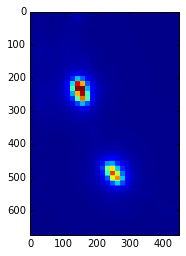

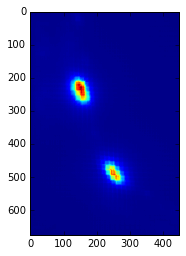

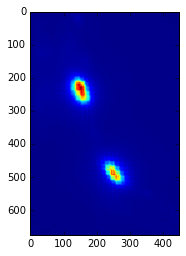

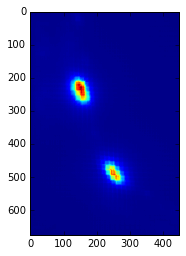

In [60]:
plt.imshow(Xguess_0[13])
plt.show()

plt.imshow(Xguess_1[13])
plt.show()
plt.imshow(Xguess_2[13])
plt.show()
plt.imshow(Xguess_3[13])
plt.show()

In [ ]:
HXguess = forwardProjectACC(H, Xguess_1, CAindex)